In [ ]:
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
torch.set_printoptions(edgeitems=1000)
import numpy as np
import copy

### アイソパラメトリック要素
[有限要素法の定式化　アイソパラメトリック要素](https://www.fem-vandv.net/c29.html)

In [ ]:
#すべての要素が同形で長方形であることを仮定(初期形状が綺麗にgrid)
class FEM2d(nn.Module):
    def __init__(self, E = 2.05 * 10**5, poisson = 0.2, elements = (4, 4), problem = "strain", per_length = (1000, 1000), t=1):#elements = (y_num, x_num), per_length(x_length, y_length)
        """
        problem: "strain" or "stress"
        """
        super(FEM2d, self).__init__()
        self.elements = elements 
        self.poisson = poisson
        self.E = E
        self.per_length = per_length
        self.problem = problem
        self.gauss =  torch.tensor([
                                    [-1 / np.sqrt(3), -1 / np.sqrt(3)],
                                    [1 / np.sqrt(3), -1 / np.sqrt(3)],
                                    [1 / np.sqrt(3), 1 / np.sqrt(3)],
                                    [-1 / np.sqrt(3), 1 / np.sqrt(3)]
                                    ])#順番合わせる
        self.t = t
        #拘束
        self.condition = []
        #要素番号
        self.elm_num = []
        #接点にかける力
        self.force = []
        #応力
        self.b_matrix = []
        self.d_matrix = []
        self.k_matrix = []#条件によらない
        self.n_matrix = []
        #result ->force, dp
        self.res_f = []
        self.dp = []

    def von_mises(self, elmt_idx):
      y_idx = elmt_idx // self.elements[1]
      x_idx = elmt_idx % self.elements[1]
      node_x = self.elements[1] + 1

      #B matrix
      #part2(解法)
      x = self.per_length[0] / 2
      y = self.per_length[1] / 2
      A = torch.tensor([
                        [1, 0, 0, 0], 
                        [1, self.per_length[0], 0, 0], 
                        [1, self.per_length[0], self.per_length[1], self.per_length[0] * self.per_length[1]], 
                        [1, 0, self.per_length[1], 0]
                        ], dtype=torch.float32)
      # """
      A_inv = torch.linalg.inv(A)#pinvやqr分解を利用した逆行列は誤差がかなり生じるのでできれば普通の逆行列を用いた方がいい
      res_matrix = torch.zeros(3, 8)#B
      res_matrix[0,::2] = A_inv[1,:] + A_inv[3,:] * y
      res_matrix[1,1::2] =  A_inv[2,:] + A_inv[3,:] * x
      res_matrix[2,::2] = A_inv[2,:] + A_inv[3,:] * x
      res_matrix[2,1::2] = A_inv[1,:] + A_inv[3,:] * y

      #変位の抽出
      ##存在する要素の(節点番号->dpのindex)をlistとして格納する。
      node2ex_idx = torch.zeros(len(self.condition),dtype = torch.int64) - 1
      node2ex_idx[self.condition != -1] = torch.arange(len(self.condition[self.condition != -1]))
      idx_tmp = []
      idx_tmp.append(y_idx * node_x + x_idx)
      idx_tmp.append(y_idx * node_x + (x_idx + 1))
      idx_tmp.append((y_idx + 1) * node_x + (x_idx + 1))
      idx_tmp.append((y_idx + 1) * node_x + x_idx)
      idx_tmp = torch.tensor(idx_tmp)
      uv_dp = torch.zeros(8)
      uv_dp[::2] = self.dp[ 2 * node2ex_idx[idx_tmp] ]#変位を修正する真ん中から見たもの
      uv_dp[1::2] = self.dp[ 2 * node2ex_idx[idx_tmp] + 1]

      #応力
      stress = torch.mm(self.d_matrix, torch.mm(res_matrix, uv_dp[:,None]))
      sigma1 = (stress[0] + stress[1]) / 2 + torch.sqrt( ((stress[0] - stress[1]) / 2)**2 + stress[2]**2)
      sigma2 = (stress[0] + stress[1]) / 2 - torch.sqrt( ((stress[0] - stress[1]) / 2)**2  + stress[2]**2)
      von = torch.sqrt(( sigma1**2 + sigma2**2 + (sigma1 - sigma2)**2) / 2)
      return von

    def B_matrix(self):
        a = torch.zeros(8)
        a[0] = 2 * self.per_length[0] / 4
        a[1] = a[5] =  a[3] = a[7] = a[2] =  a[4] = 0
        a[6] = 2 * self.per_length[1] / 4

        b = torch.zeros(3)
        b[0] = a[0] * a[6] - a[2] * a[4]
        b[1] = a[0] * a[3] - a[2] * a[1]#0
        b[2] = a[1] * a[6] - a[3] * a[4]#0

        c = torch.zeros(12)
        c[:3] = torch.tensor([-1 * self.per_length[0], -1 * self.per_length[0], 0])
        c[3:6] = torch.tensor([0,  self.per_length[0], self.per_length[0]])
        c[6:9] = torch.tensor([0, -1 * self.per_length[1], -1 * self.per_length[1]])
        c[9:] = torch.tensor([-1 * self.per_length[1], -1 * self.per_length[1], 0])

        B = []
        for gauss_i, gauss_j in self.gauss.tolist():
            tmp = torch.zeros(3,8)
            tmp[0,:] = torch.tensor([
                                  c[10] - gauss_i * c[11] - gauss_j * c[9], 0,
                                  - c[7] + gauss_i * c[11] + gauss_j * c[8], 0,
                                  - c[10] + gauss_i * c[6] - gauss_j * c[9], 0,
                                  c[7] - gauss_i * c[6] + gauss_j * c[9], 0
            ])
            tmp[1,:] = torch.tensor([
                                  0, - c[4] + gauss_i * c[5] + gauss_j * c[3],
                                  0,  c[1] - gauss_i * c[5] - gauss_j * c[2],
                                  0,  c[4] - gauss_i * c[0] + gauss_j * c[2],
                                  0, - c[1] + gauss_i * c[0] - gauss_j * c[3]
            ])
            tmp[2,:] = torch.tensor([
                                  - c[4] + gauss_i * c[5] + gauss_j * c[3],
                                  c[10] - gauss_i * c[11] - gauss_j * c[9],
                                  c[1] - gauss_i * c[5] - gauss_j * c[2],
                                  - c[7] + gauss_i * c[11] + gauss_j * c[8],
                                  c[4] - gauss_i * c[0] + gauss_j * c[2],
                                  - c[10] + gauss_i * c[6] - gauss_j * c[9],
                                  - c[1] + gauss_i * c[0] - gauss_j * c[3],
                                  c[7] - gauss_i * c[6] + gauss_j * c[9]
            ])
            B.append(tmp / (8 * (b[0] + b[1] * gauss_i + b[2] * gauss_j)))
        return torch.stack(B)

    def D_matrix(self):
        D = torch.zeros(3,3)
        if self.problem == "strain":
            D[0,:] = torch.tensor([1 - self.poisson, self.poisson, 0])
            D[1,:] = torch.tensor([self.poisson, 1 - self.poisson, 0])
            D[2,:] = torch.tensor([0, 0, (1 - 2 * self.poisson) / 2])
            D *= self.E / ((1 + self.poisson) * (1 - 2 * self.poisson))
        else:
            D[0,:] = torch.tensor([1 , self.poisson, 0])
            D[1,:] = torch.tensor([self.poisson, 1 , 0])
            D[2,:] = torch.tensor([0, 0, (1 - self.poisson) / 2])
            D *= self.E / (1 - self.poisson**2)
        return D#これをかけるタイミングを考える

    def create_K_matrix(self):#
        node_x = self.elements[1] + 1
        node_y = self.elements[0] + 1

        #有効節点 * 2
        K = torch.zeros(len(self.condition), len(self.condition))#節点*2, 節点*2(関係ない-1の接点も含めてやる[あとでその行と列を除く])
        if (len(self.n_matrix) == 0):
            self.n_matrix = self.N_create()
        if (len(self.d_matrix) == 0):
            self.d_matrix = self.D_create()
        if (len(self.b_matrix) == 0):
            self.b_matrix = self.B_matrix()

        #cal _ Ke
        for elmt_idx in self.elm_num:#要素として何番目(要素がある部分だけ計算)
            #全ての要素がある場合のindex
            y_idx = elmt_idx // self.elements[1]
            x_idx = elmt_idx % self.elements[1]
            crd = torch.tensor([
                                [x_idx * self.per_length[0], y_idx * self.per_length[1]],#左下
                                [(x_idx + 1) * self.per_length[0], y_idx * self.per_length[1]],#右下
                                [(x_idx + 1) * self.per_length[0], (y_idx + 1) * self.per_length[1]],#右上
                                [x_idx * self.per_length[0], (y_idx + 1) * self.per_length[1]]#左上
            ])# 4x2
            """
            #B_xy
            xy_e = torch.mm(self.n_matrix, crd)
            """
            #jacob
            detJ = self.J_create(crd)
            for j in range(len(self.gauss)):#4つの点で計算
                if j == 0:
                    res = detJ[j] * torch.mm(torch.mm(torch.t(self.b_matrix[j]), self.d_matrix), self.b_matrix[j])# 8 x 8
                else:
                    res += detJ[j] * torch.mm(torch.mm(torch.t(self.b_matrix[j]), self.d_matrix), self.b_matrix[j])

            #Ke -> K
            node_idx = torch.zeros(8, dtype=torch.int64)
            tmp = torch.tensor([
                                    y_idx * node_x + x_idx, #左下
                                    y_idx * node_x + (x_idx + 1),#右下
                                    (y_idx + 1) * node_x + (x_idx + 1),#右上
                                    (y_idx + 1) * node_x + x_idx#左上
                                    ])#節点番号
            node_idx[::2] = tmp * 2#u方向
            node_idx[1::2] = tmp * 2 + 1#v方向
            x_, y_ = torch.meshgrid(node_idx, node_idx, indexing='ij')
            K[x_, y_] += self.t * res#Ke->K
        #上:OK

        #
        idx_ext = self.condition != -1#(関係ない-1の節点[あとでその行と列を除く])
        self.k_matrix = copy.deepcopy(K[idx_ext][:, idx_ext])
        return self.k_matrix

    def N_create(self):
        N = []
        for gauss_i, gauss_j in self.gauss:#左下、右下、右上、左上
            N.append([
                              (1- gauss_i) * (1 - gauss_j) / 4,
                              (1+ gauss_i) * (1 - gauss_j) / 4,
                              (1- gauss_i) * (1 - gauss_j) / 4,
                              (1- gauss_i) * (1 - gauss_j) / 4])
        return torch.tensor(N)

    def J_create(self, crd):
        J_el = []#8 x 4
        for gauss_i, gauss_j in self.gauss:
            J_el.append([
                        -(1 - gauss_j) / 4,
                        (1 - gauss_j) / 4,
                        (1 + gauss_j) / 4,
                        -(1 + gauss_j) / 4
            ])
            J_el.append([
                        -(1 - gauss_i) / 4,
                        -(1 + gauss_i) / 4,
                        (1 + gauss_i) / 4,
                        (1 - gauss_i) / 4
            ])
        J_el = torch.tensor(J_el)#8 x 4
        J_diff = torch.mm(J_el.to(torch.float32), crd.to(torch.float32))# 8 x 2
        detJ = []
        for i in range(4):
            tmp = torch.tensor([
                                [J_diff[2 * i][0],  J_diff[2 * i + 1][0]],
                                [J_diff[2 * i][1],  J_diff[2 * i + 1][1]]
            ])
            detJ.append(torch.det(tmp))
        return torch.tensor(detJ)
      
    def matrix_clear(self):
        #拘束
        self.condition = []
        #要素番号
        self.elm_num = []
        #接点にかける力
        self.force = []
        #応力
        self.b_matrix = []
        self.d_matrix = []
        self.k_matrix = []
        self.n_matrix = []
        return []

    #:OK
    def set_condition(self, elmt, thresh, d_condition):#2次元の情報 (y_num + 1, 2*(x_num + 1)) 0 拘束 1自由　それ以外　力
        """
        elmt:要素があるかないかを判断する元の 2d matrix(番号関係なしに形)
        下の行の要素が形として下に来る
        thresh : 要素があるかないかを判断
        d_condition: (y_num + 1, 2*(x_num + 1)) の2次元接点条件matrix  0 拘束 1自由 or 要素がない　それ以外　力
        """
        #入力処理の前準備:OK
        node_x = torch.tensor(self.elements[1] + 1 )
        x_num = torch.tensor(elmt.shape[1])
        y_num = torch.tensor(elmt.shape[0])
        #要素を下の行から読み込むため:OK
        idx = torch.arange(-1, -1 * len(elmt) - 1, step=-1)
        e_condition = elmt[idx].flatten()#要素 x_num * y_num
        #節点の条件を下の行から読み込む:OK
        idx = torch.arange(-1, -1 * len(d_condition) - 1, step=-1)
        node_tmp = d_condition[idx].flatten()#接点の条件

        #要素番号:OK
        tmp = torch.arange(x_num * y_num)
        elm_num = tmp[e_condition >  thresh]#要素がある番号だけ取り出す
        self.elm_num = elm_num

        #要素がないところを-1にする(力がかかっている接点でも、よそがなければ-1にする)
        con_tmp = torch.zeros(len(node_tmp))#節点の数*2

        #要素があるものの中で:OK
        x_idx = self.elm_num % x_num#左から何番目の要素か
        y_idx = self.elm_num // x_num#下から何番目の要素か
      
        #要素の左下の節点のu,v方向:OK
        idx_tmp = 2*(y_idx * node_x + x_idx)
        con_tmp[idx_tmp] = 1
        con_tmp[idx_tmp + 1] = 1
        #要素の右下の節点のu,v方向:OK
        idx_tmp = 2*(y_idx * node_x + (x_idx + 1))
        con_tmp[idx_tmp] = 1
        con_tmp[idx_tmp + 1] = 1
        #要素の左上の節点のu,v方向:OK
        idx_tmp = 2*((y_idx + 1) * node_x + x_idx)
        con_tmp[idx_tmp] = 1
        con_tmp[idx_tmp + 1] = 1
        #要素の右上の節点のu,v方向:OK
        idx_tmp = 2*((y_idx + 1) * node_x + (x_idx + 1))
        con_tmp[idx_tmp] = 1
        con_tmp[idx_tmp + 1] = 1

        #d_conditionの力だけ取り出す
        self.force = torch.zeros(len(node_tmp), dtype=torch.float32)#(y_num + 1, 2*(x_num + 1))
        f_con = (node_tmp != 0) & (node_tmp != 1)#forceの位置
        self.force[f_con] = node_tmp[f_con].to(self.force.dtype)#d_conditionの力だけ取り出す(無い節点に力をかけている場合は、その力は無視される)

        #con_tmpが0のものは使われない節点:OK
        node_tmp[con_tmp == 0] = -1#接点がないところを -1にする

        #接点にかける力:OK
        #節点がないのも含む
        f_true = (node_tmp != 0) & (node_tmp != 1) & (node_tmp != -1)

        #拘束:OK
        c_true = f_true != True
        #節点がないのも含む
        self.condition = torch.ones(len(node_tmp), dtype=torch.int64)#(y_num + 1) * 2*(x_num + 1)):力がかかっているところも1にするため,onesを使う
        self.condition[c_true] = node_tmp[c_true]#0:拘束 1:自由　-1:関係なし
        return self.force, self.condition

    #
    def cal_deplace(self):
        if (len(self.d_matrix) == 0):
            self.d_matrix = self.D_matrix()
        if (len(self.b_matrix) == 0):
            self.b_matrix = self.B_matrix()
        if (len(self.k_matrix) == 0):
            self.k_matrix = self.create_K_matrix()
        dpl = torch.zeros(len(self.k_matrix))
        #cal
        cond_tmp = self.condition[self.condition != -1]#節点がある部分だけ抽出
        force_tmp = self.force[self.condition != -1]#節点がある部分だけ抽出
        #拘束している部分を除く
        con_l = cond_tmp == 1#False == 0拘束するところ
        #逆行列を求める
        k_sub = self.k_matrix[con_l][:,con_l]#変位できる部分
        #解の存在条件, qr分解の方が精度が良い
        k_inv = torch.linalg.inv(k_sub)
        dpl[con_l,None] = torch.mm(k_inv, force_tmp[con_l][:,None])#拘束以外の所の変位
        #変位->支持点の力
        force = torch.mm(self.k_matrix, dpl[:,None])#力
        return  force.squeeze(), dpl

    def forward(self, elmt, thresh, d_condition):
        """
        elmt:要素があるかないかを判断する元の 2d matrix
        thresh : 要素があるかないかを判断
        d_condition: (y_num + 1, 2*(x_num + 1)) の2次元接点条件matrix  0 拘束 1自由 or 要素がない　それ以外　力
        """
        #要素
        pre_f, pre_con = self.set_condition(elmt, thresh, d_condition)
        #変位の計算
        force, dpl = self.cal_deplace()
        self.res_f = force
        self.dp = dpl
        return force, dpl

In [ ]:
# fem = FEM2d(elements = (2, 2))
# fem = FEM2d(elements = (3, 3))
# fem = FEM2d(elements = (5, 5))
# fem = FEM2d(elements = (3, 6), per_length=(100, 50))
fem = FEM2d(elements = (15, 30), per_length=(20, 10))

In [ ]:
#要素 thresh以下は要素なしと判定
# elmt = torch.tensor([[1, 1], [1, 1]])#2x2
# elmt = torch.tensor([[1, 1, 1], [1, 1, 1], [1, 1, 1]])#3x3
# elmt = torch.tensor([[1, 1, 1, 1, 1],[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]])#5x5
# elmt = torch.tensor([[0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 0], [1, 1, 0, 0, 1, 1]])#3x6
elmt = torch.ones(15,30, dtype=torch.int64)#15 x 30
# elmt[0,-1] = -1

thresh = 0
#力、固定の条件(-1 は使わない)
# d_condition = torch.tensor([[0, 0, 1, 1, 1, -1000], [0, 0, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1]])#2x2
# d_condition = torch.tensor([[0, 0, 1, -2000, 1, -2000, 1, -1000], [0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1]])#3x3
# d_condition = torch.tensor([[0, 0, 1, -2000, 1, -2000, 1, -2000, 1, -2000, 1, -1000], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])#5x5
# d_condition = torch.tensor([[0, 0, 1, -2000, 1, -2000, 1, -2000, 1, -2000, 1, -2000,  1, -1000], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])#3x6
# d_condition = torch.tensor([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  1, -1000], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])#3x6
# d_condition = torch.tensor([[1, 1, 1, 1, 1, 1, 1, -1000, 1, 1, 1, 1,  1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])
d_condition = torch.ones(16, 31*2, dtype=torch.int64)
d_condition[-1,:2] = 0
d_condition[-1,torch.tensor([-1, -2])] = 0
d_condition[0,torch.tensor([31])] = -1000
# d_condition[0,-1] = -1000

In [ ]:
fem.matrix_clear()

[]

In [ ]:
print(elmt.shape, d_condition.shape)

torch.Size([15, 30]) torch.Size([16, 62])


In [ ]:
f, dp= fem(elmt, thresh, d_condition)
#qrによるものとpinvを比べると解の条件的にはpinv(閾値なし)の方が小さくなる(0にちかくなる)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


In [ ]:
print(len(f), len(dp))

992 992


### 精度の検証

$$
\begin{align}
v = \frac{Pl^3}{3EI} \\
I = \frac{bh^3}{12} \\
\end{align} \\
$$

$$
l = 600 [mm] \\
E = 2.05 \times 10^5 [N/mm^2] \\
h = 150 [mm] \\
b = 1 [mm] \\
v = 1.24878 [mm]
$$

496 496 496 992


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


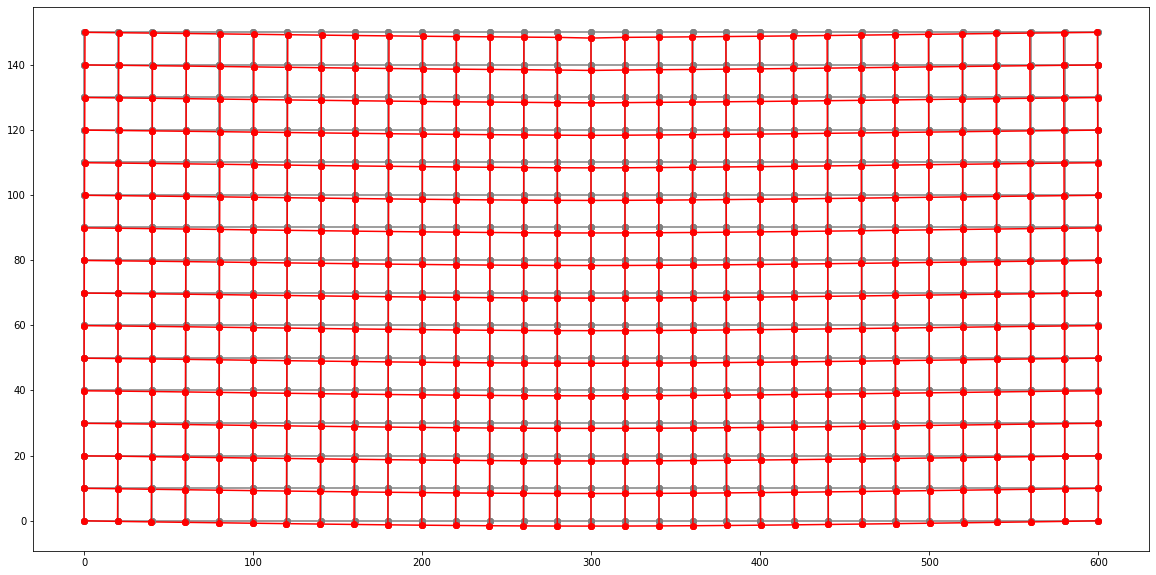

In [ ]:
# d_condition yの接点数 * (xの接点数*2)
import matplotlib.pyplot as plt
import copy 

scale = 10*3
fig = plt.figure(figsize=[20,10])

ax = fig.add_subplot(1, 1, 1)
x_num = d_condition.shape[1] // 2#x方向の節点数
#節点のある部分 initial_x, initial_y
node_con = copy.deepcopy(fem.condition).reshape(d_condition.shape[0], d_condition.shape[1])[:, ::2]
initial_y, initial_x = np.where(node_con >= 0)
initial_x *= fem.per_length[0]
initial_y *= fem.per_length[1]
nf = node_con.flatten()
node_ex = torch.arange(len(nf))[nf != -1].to(torch.int64)#存在する節点番号
print(len(initial_x), len(initial_y), len(node_ex), len(dp))
# print(node_ex)

#存在する要素の(節点番号->dpのindex)をlistとして格納する。
node2ex_idx = torch.zeros(len(nf),dtype = torch.int64) - 1
# print(node_ex.dtype, node2ex_idx.dtype)
node2ex_idx[node_ex] = torch.arange(len(node_ex))

pre_dp = copy.deepcopy(dp)
pre_dp = pre_dp * scale
pre = []
for i, x, y in zip(node_ex, initial_x, initial_y):#接点がない場合を考えないといけない
    if (i == 0):
      pre.append((x, y))
      continue
    #x,y につながっている線を考える
    #要素がない場合も考える
    elm_idx = i % x_num
    if elm_idx > 0:
      elm_idx -= 1
    elm_idy = i // x_num 
    k_elm = elm_idx  + elm_idy * (x_num - 1)
    if ((x - fem.per_length[0], y) in pre and (k_elm in fem.elm_num or (k_elm - x_num + 1) in fem.elm_num)):#その節点があるかどうか
      ax.plot([x - fem.per_length[0], x], [y, y], color="gray", marker="o")#初期の位置
      idx = node2ex_idx[i - 1]#左隣の節点
      ax.plot([x - fem.per_length[0] + pre_dp[2*idx], x + pre_dp[2* node2ex_idx[i]]], [y + pre_dp[2*idx + 1], y + pre_dp[2*node2ex_idx[i] + 1]], color="red", marker="o")#変化後の位置
    if ((x,  y - fem.per_length[1]) in pre and ((k_elm - x_num + 2) in fem.elm_num or (k_elm - x_num + 1) in fem.elm_num)):#端の場合を考えていない
      if ((i % x_num == 0 and  (k_elm - x_num + 1) not in fem.elm_num) or (i % x_num == x_num - 1 and  (k_elm - x_num + 1) not in fem.elm_num)):
        pass
      else:
        ax.plot([x , x], [y - fem.per_length[1], y], color="gray", marker="o")
        idx = node2ex_idx[i - x_num]#下の節点
        ax.plot([x + pre_dp[2*idx], x + pre_dp[2*node2ex_idx[i]]], [y - fem.per_length[1] + pre_dp[2*idx + 1], y + pre_dp[2*node2ex_idx[i] + 1]], color="red", marker="o")
    #変位の表示
    if (i % x_num == x_num - 1):
      pass
      # ax.text(x + pre_dp[2*node2ex_idx[i]],  y + pre_dp[2*node2ex_idx[i] + 1], "({:.3f}, {:.3f})".format(dp[2*node2ex_idx[i]].item(), dp[2*node2ex_idx[i] + 1].item()), size=10)
    pre.append((x, y))
plt.show()

496 496 496 992


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


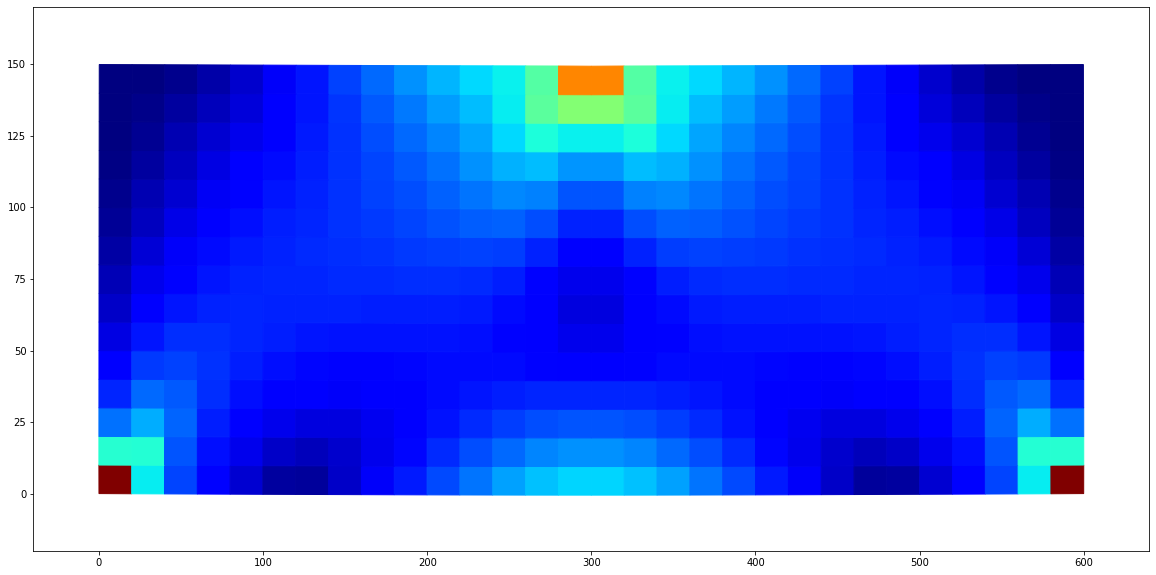

In [ ]:
# d_condition yの接点数 * (xの接点数*2)
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import copy 

scale = 10
fig = plt.figure(figsize=[20,10])

ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(-2 * fem.per_length[0], fem.elements[1] * fem.per_length[0] + 2 * fem.per_length[0])
ax.set_ylim(-2 * fem.per_length[1], fem.elements[0] * fem.per_length[1] + 2 * fem.per_length[1])

node_x = fem.elements[1] + 1
x_num = d_condition.shape[1] // 2#x方向の節点数
#節点のある部分 initial_x, initial_y
node_con = copy.deepcopy(fem.condition).reshape(d_condition.shape[0], d_condition.shape[1])[:, ::2]
initial_y, initial_x = np.where(node_con >= 0)
initial_x *= fem.per_length[0]
initial_y *= fem.per_length[1]
initial_x =  torch.from_numpy(initial_x).clone()
initial_y =  torch.from_numpy(initial_y).clone()

nf = node_con.flatten()
node_ex = torch.arange(len(nf))[nf != -1].to(torch.int64)#存在する節点番号
print(len(initial_x), len(initial_y), len(node_ex), len(dp))
# print(node_ex)

#存在する要素の(節点番号->dpのindex)をlistとして格納する。
node2ex_idx = torch.zeros(len(nf),dtype = torch.int64) - 1
# print(node_ex.dtype, node2ex_idx.dtype)
node2ex_idx[node_ex] = torch.arange(len(node_ex))
"""
      node2ex_idx = torch.zeros(len(self.condition),dtype = torch.int64) - 1
      node2ex_idx[self.condition != -1] = torch.arange(len(self.condition[self.condition != -1]))
"""
pre_dp = copy.deepcopy(dp)
pre_dp = pre_dp * scale
pre = []

 
#フォン・ミーゼス応力
von_stress = []
for elm_idx in fem.elm_num:
  von_stress.append(fem.von_mises(elm_idx))
von_stress = torch.tensor(von_stress)
if (torch.min(von_stress) != 0 and torch.max(von_stress) != 0):
  von_stress = (von_stress - torch.min(von_stress)) / (torch.max(von_stress) - torch.min(von_stress))
cmap = plt.cm.get_cmap("jet")

for i, elm_idx in enumerate(fem.elm_num):#接点がない場合を考えないといけない
    x_idx = elm_idx % fem.elements[1]
    y_idx = elm_idx // fem.elements[1]
    idx_tmp = []
    #node2ex_idx を使う
    idx_tmp.append( y_idx * node_x + x_idx)
    idx_tmp.append(y_idx * node_x + (x_idx + 1))
    idx_tmp.append((y_idx + 1) * node_x + (x_idx + 1))
    idx_tmp.append((y_idx + 1) * node_x + x_idx)
    idx_tmp = torch.tensor(idx_tmp)

    #座標を求める
    x_ = initial_x[idx_tmp] + pre_dp[2*idx_tmp]
    y_ = initial_y[idx_tmp] + pre_dp[2*idx_tmp + 1]
    # """
    xy_cord = torch.cat((x_[:,None], y_[:,None]), dim = 1)
    p = pat.Polygon(xy = xy_cord.tolist(), alpha = cmap(von_stress[i].item())[-1] , color=cmap(von_stress[i].item())[:3])
    ax.add_patch(p)
    """
    ax.fill(x_.tolist(), y_.tolist(), fill=False, hatch='//', linewidth=2.0, edgecolor='red')
    """

plt.show()